Erreur de reconstruction (norme L2) : 0.8975110042029061


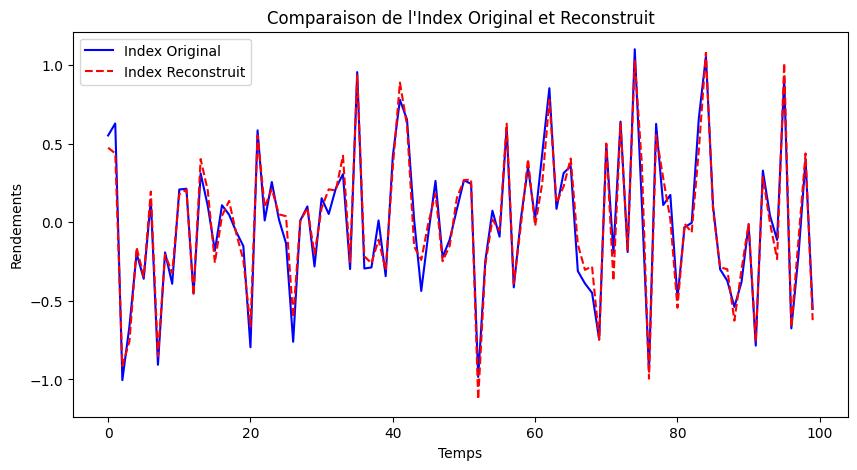

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def decompose_cluster_index(asset_returns: pd.DataFrame, index_returns: pd.Series):
    """
    Decomposes the index of a cluster into uncorrelated asset components.
    
    Parameters:
    asset_returns: pd.DataFrame, shape (T, N)
        Time series of N asset returns.
    index_returns: pd.Series, shape (T,)
        Time series of the index of the cluster.
        
    Returns:
    - components: List of pd.Series
        A list of time series that sum to the index and are uncorrelated.
    - component_variances: np.ndarray
        The variances of the components, summing to the variance of the index.
    """
    assets = asset_returns.copy()
    index = index_returns.copy()
    
    # Step 2: Remove means
    assets = assets - assets.mean()
    index = index - index.mean()
    
    components = []
    component_variances = []
    
    while len(assets.columns) > 0:
        best_asset = None
        best_residual_var = float('inf')
        best_beta = None
        best_residuals = None
        
        # Step 3: Regress each asset against the index and find the best fit
        for asset in assets.columns:
            X = assets[[asset]].values
            y = np.asarray(index)
            model = LinearRegression()
            model.fit(X, y)
            residuals = y - model.predict(X)
            residual_var = np.var(residuals)
            
            if residual_var < best_residual_var:
                best_residual_var = residual_var
                best_asset = asset
                best_beta = model.coef_[0]
                best_residuals = residuals
        
        # Step 4 & 5: Store the component
        new_component = best_beta * assets[best_asset]
        components.append(new_component)
        component_variances.append(np.var(new_component))
        
        # Step 6: Replace remaining series by stripping out beta to best asset
        new_assets = {}
        for asset in assets.columns:
            if asset != best_asset:
                X = assets[[best_asset]].values
                y = assets[asset].values
                model = LinearRegression()
                model.fit(X, y)
                new_residuals = y - model.predict(X)
                new_assets[asset] = new_residuals
        
        assets = pd.DataFrame(new_assets, index=assets.index)
        index = best_residuals  # Step 4: Update index to be explained
    
    return components, np.array(component_variances)

# Example usage:
np.random.seed(42)
T, N = 100, 5  # 100 time periods, 5 assets
asset_returns = pd.DataFrame(np.random.randn(T, N), columns=[f'Asset_{i}' for i in range(N)])
index_returns = asset_returns.mean(axis=1) + np.random.randn(T) * 0.1  # Simulated cluster index

components, component_variances = decompose_cluster_index(asset_returns, index_returns)

# Verify results
reconstructed_index = sum(components)
difference = np.linalg.norm(reconstructed_index - index_returns)
print("Erreur de reconstruction (norme L2) :", difference)

# Plot the original index and the reconstructed one
plt.figure(figsize=(10, 5))
plt.plot(index_returns, label='Index Original', linestyle='-', color='blue')
plt.plot(reconstructed_index, label='Index Reconstruit', linestyle='--', color='red')
plt.legend()
plt.title("Comparaison de l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.show()


[*********************100%***********************]  9 of 9 completed


Erreur de reconstruction (norme L2) : 0.042883281931958714


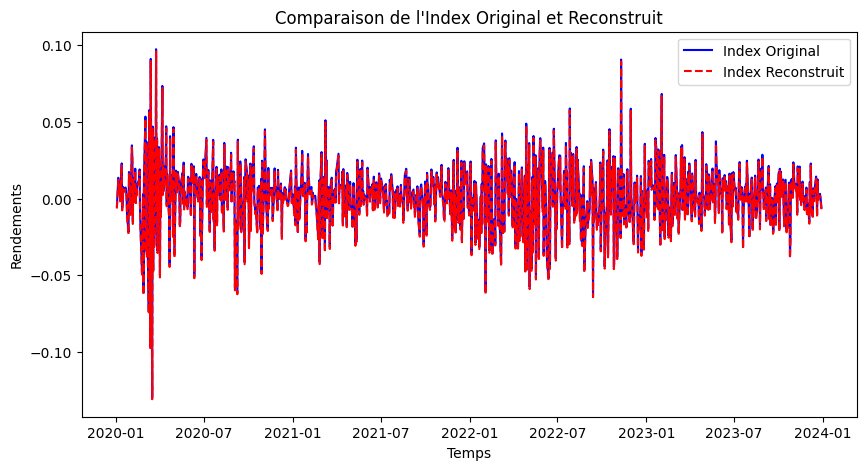

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
yf = __import__('yfinance')

def decompose_cluster_index(asset_returns: pd.DataFrame, index_returns: pd.Series):
    """
    Decomposes the index of a cluster into uncorrelated asset components.
    
    Parameters:
    asset_returns: pd.DataFrame, shape (T, N)
        Time series of N asset returns.
    index_returns: pd.Series, shape (T,)
        Time series of the index of the cluster.
        
    Returns:
    - components: List of pd.Series
        A list of time series that sum to the index and are uncorrelated.
    - component_variances: np.ndarray
        The variances of the components, summing to the variance of the index.
    """
    assets = asset_returns.copy()
    index = index_returns.copy()
    
    # Step 2: Remove means
    assets = assets - assets.mean()
    index = index - index.mean()
    
    components = []
    component_variances = []
    
    while len(assets.columns) > 0:
        best_asset = None
        best_residual_var = float('inf')
        best_beta = None
        best_residuals = None
        
        # Step 3: Regress each asset against the index and find the best fit
        for asset in assets.columns:
            X = assets[[asset]].values
            y = np.asarray(index)
            model = LinearRegression()
            model.fit(X, y)
            residuals = y - model.predict(X)
            residual_var = np.var(residuals)
            
            if residual_var < best_residual_var:
                best_residual_var = residual_var
                best_asset = asset
                best_beta = model.coef_[0]
                best_residuals = residuals
        
        # Step 4 & 5: Store the component
        new_component = best_beta * assets[best_asset]
        components.append(new_component)
        component_variances.append(np.var(new_component))
        
        # Step 6: Replace remaining series by stripping out beta to best asset
        new_assets = {}
        for asset in assets.columns:
            if asset != best_asset:
                X = assets[[best_asset]].values
                y = assets[asset].values
                model = LinearRegression()
                model.fit(X, y)
                new_residuals = y - model.predict(X)
                new_assets[asset] = new_residuals
        
        assets = pd.DataFrame(new_assets, index=assets.index)
        index = best_residuals  # Step 4: Update index to be explained
    
    return components, np.array(component_variances)

# Download historical stock data
symbols = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'BRK-B']
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Close']

# Compute daily returns
returns = data.pct_change().dropna()

# Define the index as an equal-weighted portfolio
index_returns = returns.mean(axis=1)

# Decompose the index
components, component_variances = decompose_cluster_index(returns, index_returns)

# Verify results
reconstructed_index = sum(components)
difference = np.linalg.norm(reconstructed_index - index_returns)
print("Erreur de reconstruction (norme L2) :", difference)

# Plot the original index and the reconstructed one
plt.figure(figsize=(10, 5))
plt.plot(index_returns, label='Index Original', linestyle='-', color='blue')
plt.plot(reconstructed_index, label='Index Reconstruit', linestyle='--', color='red')
plt.legend()
plt.title("Comparaison de l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.show()


In [11]:
index_returns

Date
2020-01-03   -0.005088
2020-01-06    0.013624
2020-01-07    0.003786
2020-01-08    0.011192
2020-01-09    0.008355
                ...   
2023-12-22   -0.000378
2023-12-26    0.003180
2023-12-27    0.001235
2023-12-28   -0.002530
2023-12-29   -0.005821
Length: 1005, dtype: float64

In [12]:
reconstructed_index

Date
2020-01-03   -0.006441
2020-01-06    0.012271
2020-01-07    0.002433
2020-01-08    0.009840
2020-01-09    0.007002
                ...   
2023-12-22   -0.001731
2023-12-26    0.001827
2023-12-27   -0.000118
2023-12-28   -0.003883
2023-12-29   -0.007174
Length: 1005, dtype: float64

[*********************100%***********************]  9 of 9 completed

Erreur de reconstruction (norme L2) : 0.042883281931958714
Somme des variances des composantes : 0.00040332982710726025
Variance de l'index : 0.0004033298271072593


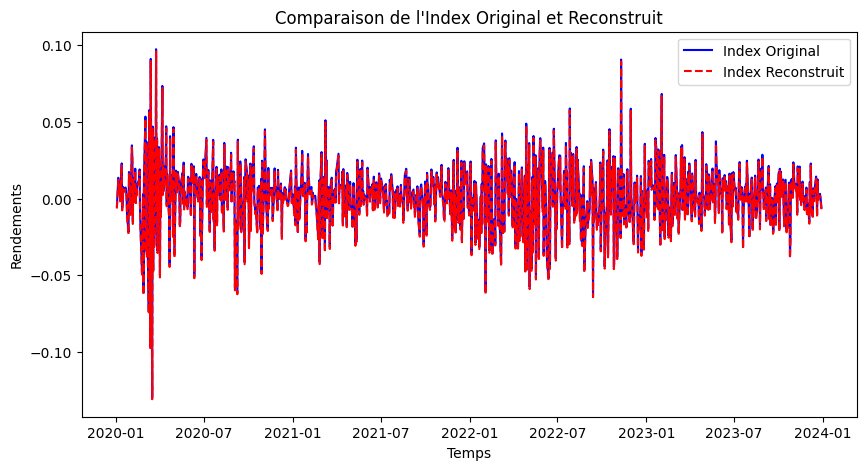

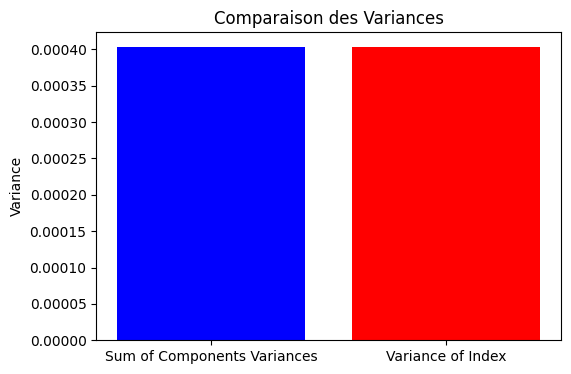

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
yf = __import__('yfinance')

def decompose_cluster_index(asset_returns: pd.DataFrame, index_returns: pd.Series):
    """
    Decomposes the index of a cluster into uncorrelated asset components.
    
    Parameters:
    asset_returns: pd.DataFrame, shape (T, N)
        Time series of N asset returns.
    index_returns: pd.Series, shape (T,)
        Time series of the index of the cluster.
        
    Returns:
    - components: List of pd.Series
        A list of time series that sum to the index and are uncorrelated.
    - component_variances: np.ndarray
        The variances of the components, summing to the variance of the index.
    """
    assets = asset_returns.copy()
    index = index_returns.copy()
    
    # Step 2: Remove means
    assets = assets - assets.mean()
    index = index - index.mean()
    
    components = []
    component_variances = []
    
    while len(assets.columns) > 0:
        best_asset = None
        best_residual_var = float('inf')
        best_beta = None
        best_residuals = None
        
        # Step 3: Regress each asset against the index and find the best fit
        for asset in assets.columns:
            X = assets[[asset]].values
            y = np.asarray(index)
            model = LinearRegression()
            model.fit(X, y)
            residuals = y - model.predict(X)
            residual_var = np.var(residuals)
            
            if residual_var < best_residual_var:
                best_residual_var = residual_var
                best_asset = asset
                best_beta = model.coef_[0]
                best_residuals = residuals
        
        # Step 4 & 5: Store the component
        new_component = best_beta * assets[best_asset]
        components.append(new_component)
        component_variances.append(np.var(new_component))
        
        # Step 6: Replace remaining series by stripping out beta to best asset
        new_assets = {}
        for asset in assets.columns:
            if asset != best_asset:
                X = assets[[best_asset]].values
                y = assets[asset].values
                model = LinearRegression()
                model.fit(X, y)
                new_residuals = y - model.predict(X)
                new_assets[asset] = new_residuals
        
        assets = pd.DataFrame(new_assets, index=assets.index)
        index = best_residuals  # Step 4: Update index to be explained
    
    return components, np.array(component_variances)

# Download historical stock data
symbols = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'BRK-B']
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Close']

# Compute daily returns
returns = data.pct_change().dropna()

# Define the index as an equal-weighted portfolio
index_returns = returns.mean(axis=1)

# Decompose the index
components, component_variances = decompose_cluster_index(returns, index_returns)

# Verify results
reconstructed_index = sum(components)
difference = np.linalg.norm(reconstructed_index - index_returns)
print("Erreur de reconstruction (norme L2) :", difference)
print("Somme des variances des composantes :", np.sum(component_variances))
print("Variance de l'index :", np.var(index_returns))

# Plot the original index and the reconstructed one
plt.figure(figsize=(10, 5))
plt.plot(index_returns, label='Index Original', linestyle='-', color='blue')
plt.plot(reconstructed_index, label='Index Reconstruit', linestyle='--', color='red')
plt.legend()
plt.title("Comparaison de l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.show()

# Plot the variance comparison
plt.figure(figsize=(6, 4))
plt.bar(['Sum of Components Variances', 'Variance of Index'], [np.sum(component_variances), np.var(index_returns)], color=['blue', 'red'])
plt.title("Comparaison des Variances")
plt.ylabel("Variance")
plt.show()


[*********************100%***********************]  9 of 9 completed

Erreur de reconstruction (norme L2) : 0.042883281931958714
Somme des variances des composantes : 0.00040332982710726025
Variance de l'index : 0.0004033298271072593


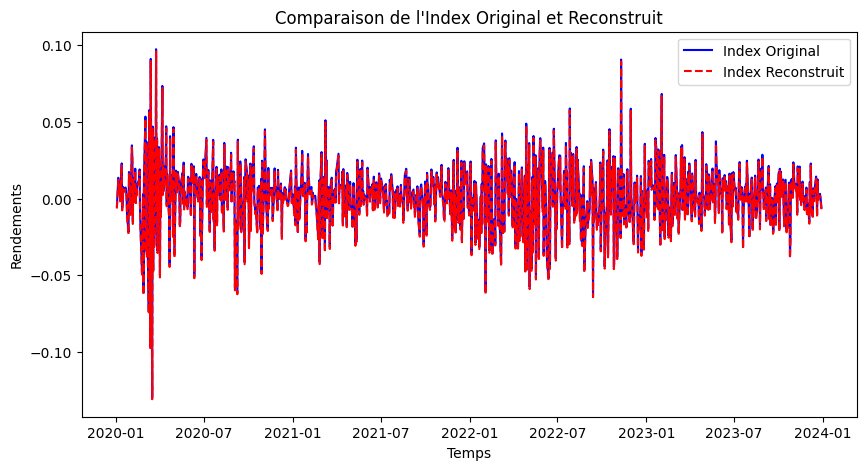

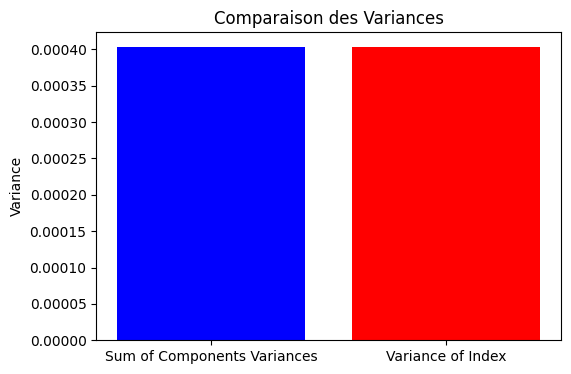

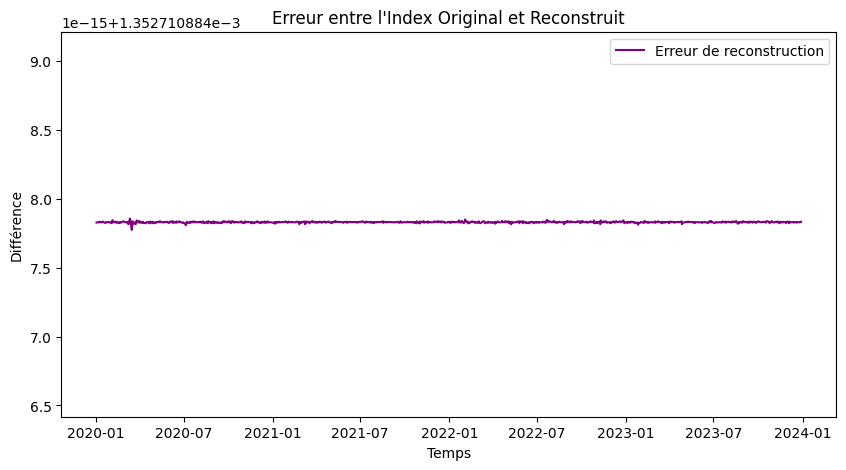

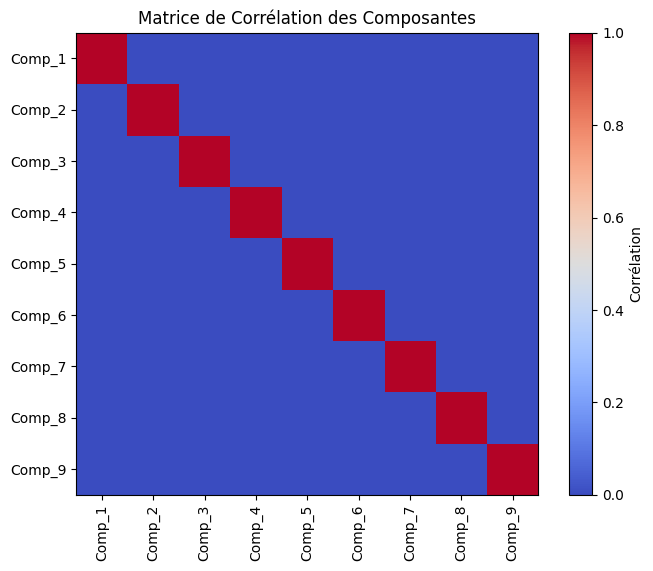

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
yf = __import__('yfinance')

def decompose_cluster_index(asset_returns: pd.DataFrame, index_returns: pd.Series):
    """
    Decomposes the index of a cluster into uncorrelated asset components.
    
    Parameters:
    asset_returns: pd.DataFrame, shape (T, N)
        Time series of N asset returns.
    index_returns: pd.Series, shape (T,)
        Time series of the index of the cluster.
        
    Returns:
    - components: List of pd.Series
        A list of time series that sum to the index and are uncorrelated.
    - component_variances: np.ndarray
        The variances of the components, summing to the variance of the index.
    """
    assets = asset_returns.copy()
    index = index_returns.copy()
    
    # Step 2: Remove means
    assets = assets - assets.mean()
    index = index - index.mean()
    
    components = []
    component_variances = []
    
    while len(assets.columns) > 0:
        best_asset = None
        best_residual_var = float('inf')
        best_beta = None
        best_residuals = None
        
        # Step 3: Regress each asset against the index and find the best fit
        for asset in assets.columns:
            X = assets[[asset]].values
            y = np.asarray(index)
            model = LinearRegression()
            model.fit(X, y)
            residuals = y - model.predict(X)
            residual_var = np.var(residuals)
            
            if residual_var < best_residual_var:
                best_residual_var = residual_var
                best_asset = asset
                best_beta = model.coef_[0]
                best_residuals = residuals
        
        # Step 4 & 5: Store the component
        new_component = best_beta * assets[best_asset]
        components.append(new_component)
        component_variances.append(np.var(new_component))
        
        # Step 6: Replace remaining series by stripping out beta to best asset
        new_assets = {}
        for asset in assets.columns:
            if asset != best_asset:
                X = assets[[best_asset]].values
                y = assets[asset].values
                model = LinearRegression()
                model.fit(X, y)
                new_residuals = y - model.predict(X)
                new_assets[asset] = new_residuals
        
        assets = pd.DataFrame(new_assets, index=assets.index)
        index = best_residuals  # Step 4: Update index to be explained
    
    return components, np.array(component_variances)

# Download historical stock data
symbols = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'BRK-B']
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Close']

# Compute daily returns
returns = data.pct_change().dropna()

# Define the index as an equal-weighted portfolio
index_returns = returns.mean(axis=1)

# Decompose the index
components, component_variances = decompose_cluster_index(returns, index_returns)

# Verify results
reconstructed_index = sum(components)
difference = np.linalg.norm(reconstructed_index - index_returns)
print("Erreur de reconstruction (norme L2) :", difference)
print("Somme des variances des composantes :", np.sum(component_variances))
print("Variance de l'index :", np.var(index_returns))

# Plot the original index and the reconstructed one
plt.figure(figsize=(10, 5))
plt.plot(index_returns, label='Index Original', linestyle='-', color='blue')
plt.plot(reconstructed_index, label='Index Reconstruit', linestyle='--', color='red')
plt.legend()
plt.title("Comparaison de l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.show()

# Plot the variance comparison
plt.figure(figsize=(6, 4))
plt.bar(['Sum of Components Variances', 'Variance of Index'], [np.sum(component_variances), np.var(index_returns)], color=['blue', 'red'])
plt.title("Comparaison des Variances")
plt.ylabel("Variance")
plt.show()

# Plot reconstruction error
plt.figure(figsize=(10, 5))
plt.plot(index_returns - reconstructed_index, label='Erreur de reconstruction', color='purple')
plt.legend()
plt.title("Erreur entre l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Différence")
plt.show()

# Check if the components are uncorrelated
components_df = pd.DataFrame(components).T
correlation_matrix = components_df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Corrélation')
plt.title("Matrice de Corrélation des Composantes")
plt.xticks(range(len(components)), labels=[f'Comp_{i+1}' for i in range(len(components))], rotation=90)
plt.yticks(range(len(components)), labels=[f'Comp_{i+1}' for i in range(len(components))])
plt.show()


[*********************100%***********************]  9 of 9 completed


Erreur de reconstruction (norme L2) : 0.042883281931958714
Somme des variances des composantes : 0.00040332982710726025
Variance de l'index : 0.0004033298271072593


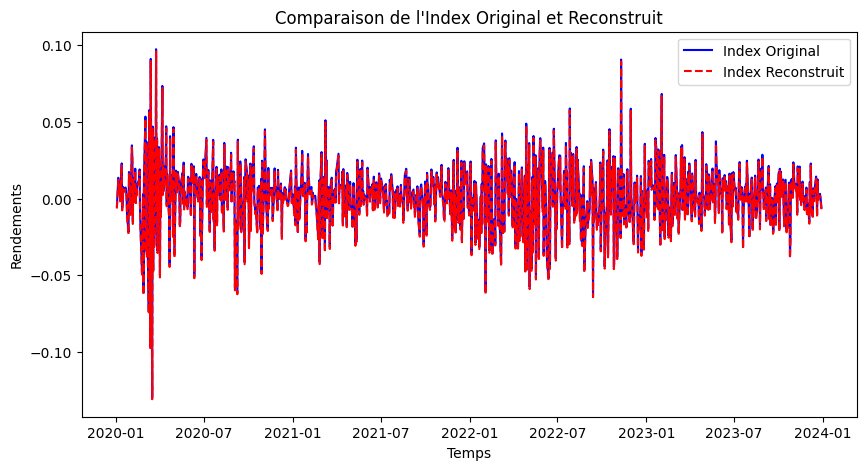

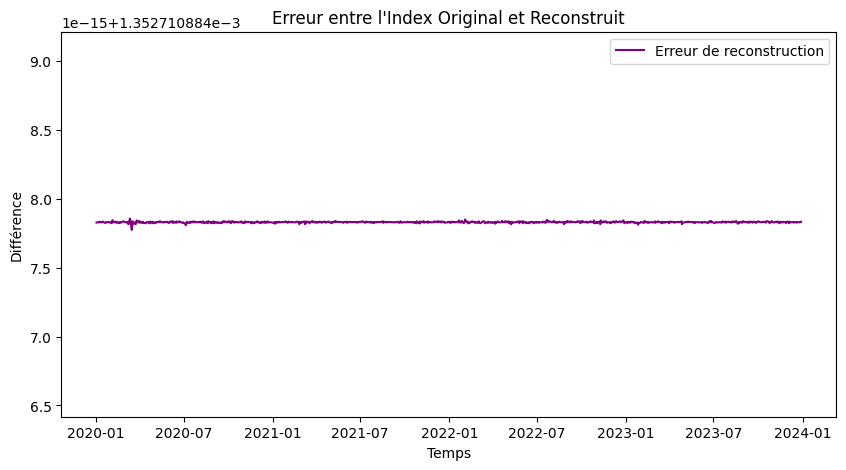

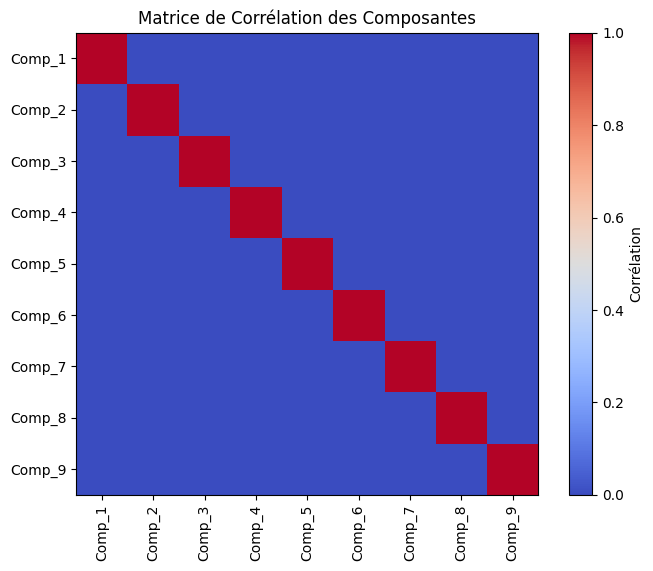

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

def decompose_cluster_index(asset_returns: pd.DataFrame, index_returns: pd.Series):
    """
    Decomposes the index of a cluster into uncorrelated asset components.
    
    Parameters:
    asset_returns: pd.DataFrame, shape (T, N)
        Time series of N asset returns.
    index_returns: pd.Series, shape (T,)
        Time series of the index of the cluster.
        
    Returns:
    - components: List of pd.Series
        A list of time series that sum to the index and are uncorrelated.
    - component_variances: np.ndarray
        The variances of the components, summing to the variance of the index.
    """
    assets = asset_returns.copy()
    index = index_returns.copy()
    
    # Step 2: Remove means
    assets = assets - assets.mean()
    index = index - index.mean()
    
    components = []
    component_variances = []
    
    while len(assets.columns) > 0:
        best_asset = None
        best_residual_var = float('inf')
        best_beta = None
        best_residuals = None
        
        # Step 3: Regress each asset against the index and find the best fit
        for asset in assets.columns:
            X = assets[[asset]].values
            y = np.asarray(index)
            model = LinearRegression()
            model.fit(X, y)
            residuals = y - model.predict(X)
            residual_var = np.var(residuals)
            
            if residual_var < best_residual_var:
                best_residual_var = residual_var
                best_asset = asset
                best_beta = model.coef_[0]
                best_residuals = residuals
        
        # Step 4 & 5: Store the component
        new_component = best_beta * assets[best_asset]
        components.append(new_component)
        component_variances.append(np.var(new_component))
        
        # Step 6: Orthogonalize remaining assets
        new_assets = {}
        for asset in assets.columns:
            if asset != best_asset:
                X = assets[[best_asset]].values
                y = assets[asset].values
                model = LinearRegression()
                model.fit(X, y)
                new_residuals = y - model.predict(X)
                new_assets[asset] = new_residuals
        
        assets = pd.DataFrame(new_assets, index=assets.index)
        index = best_residuals  # Step 4: Update index to be explained
    
    return components, np.array(component_variances)

# Download historical stock data
symbols = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'BRK-B']
data = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Close']

# Compute daily returns
returns = data.pct_change().dropna()

# Define the index as an equal-weighted portfolio
index_returns = returns.mean(axis=1)

# Decompose the index
components, component_variances = decompose_cluster_index(returns, index_returns)

# Verify results
reconstructed_index = sum(components)
difference = np.linalg.norm(reconstructed_index - index_returns)
print("Erreur de reconstruction (norme L2) :", difference)
print("Somme des variances des composantes :", np.sum(component_variances))
print("Variance de l'index :", np.var(index_returns))

# Create a DataFrame for comparison
df_comparison = pd.DataFrame({
    'Index Original': index_returns,
    'Index Reconstruit': reconstructed_index
})

# Display the table
df_comparison
# Ensure perfect reconstruction
plt.figure(figsize=(10, 5))
plt.plot(index_returns, label='Index Original', linestyle='-', color='blue')
plt.plot(reconstructed_index, label='Index Reconstruit', linestyle='--', color='red')
plt.legend()
plt.title("Comparaison de l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.show()

# Plot the reconstruction error
plt.figure(figsize=(10, 5))
plt.plot(index_returns - reconstructed_index, label='Erreur de reconstruction', color='purple')
plt.legend()
plt.title("Erreur entre l'Index Original et Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Différence")
plt.show()

# Check if the components are uncorrelated
components_df = pd.DataFrame(components).T
correlation_matrix = components_df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Corrélation')
plt.title("Matrice de Corrélation des Composantes")
plt.xticks(range(len(components)), labels=[f'Comp_{i+1}' for i in range(len(components))], rotation=90)
plt.yticks(range(len(components)), labels=[f'Comp_{i+1}' for i in range(len(components))])
plt.show()

# Display correlation matrix as a DataFrame
